# Variational AutoEncoders

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [2]:
# Displaying routine

def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))

        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [3]:
# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [4]:
# Define data loading step
# Use the MNIST Dataset with batch_size of 256

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(
                    MNIST('./data', train=True, download=True,
                    transform=transforms.ToTensor()),
                    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
                    MNIST('./data', train=False, transform=transforms.ToTensor()),
                    batch_size=batch_size, shuffle=True, **kwargs)

100.1%Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw
113.5%Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
180.4%Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [5]:
# Defining the device, i.e cpu or gpu

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Building the Model

In [6]:
# Defining the model

d = 20      # dimension

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        # Defining the Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)        # d*2, where half is for mean and the other half of variance
        )

        # Defining the Decoder
        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),        # The output dimension needs to be 784 to match the dimension of the input
            nn.Sigmoid(),                  # Value of the images will be between 0 and 1 (Real Values)
        )
    
    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()                    # Get the Standard Deviation from the log variance
            eps = std.data.new(std.size()).normal_()        # Sample from a Normal Distribution
            return eps.mul(std).add_(mu)                    # Return the epsilon multiplied by standard deviation and add the mean.
        else:
            return mu                                       # If not training, we dont need to add noise. Simply return mu, and use it in a deterministically.

    def forward(self, x):
        # Encoder gets a reshaped input unrolled into a vector.
        # The output of the encoder is reshaped into batch size of 2 and d, 
        # where d is the dimension of mean and dimension of the variance
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)        
        mu = mu_logvar[:, 0, :]                                     # Extract the mean
        logvar = mu_logvar[:, 1, :]                                 # Extract the log variance

        # Latent Variable - given the mean and log variance (to use the whole real range)
        z = self.reparameterise(mu, logvar)

        return self.decoder(z), mu, logvar

# Instantiate the VAE and send it to the device.
model = VAE().to(device)

In [7]:
# Setting up the Adam optimiser.

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [8]:
# Defining the Loss Function.
# Reconstruction + KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD

====> Test set loss: 544.4378
====> Epoch: 1 Average loss: 190.8732
====> Test set loss: 138.4325
====> Epoch: 2 Average loss: 133.0498
====> Test set loss: 115.1159
====> Epoch: 3 Average loss: 120.7396
====> Test set loss: 108.2985
====> Epoch: 4 Average loss: 115.8852
====> Test set loss: 105.0410
====> Epoch: 5 Average loss: 113.1244
====> Test set loss: 102.2898
====> Epoch: 6 Average loss: 111.3621
====> Test set loss: 101.4036
====> Epoch: 7 Average loss: 110.0321
====> Test set loss: 99.9375
====> Epoch: 8 Average loss: 109.0987
====> Test set loss: 99.2949
====> Epoch: 9 Average loss: 108.3523
====> Test set loss: 98.2976
====> Epoch: 10 Average loss: 107.7429
====> Test set loss: 97.6890


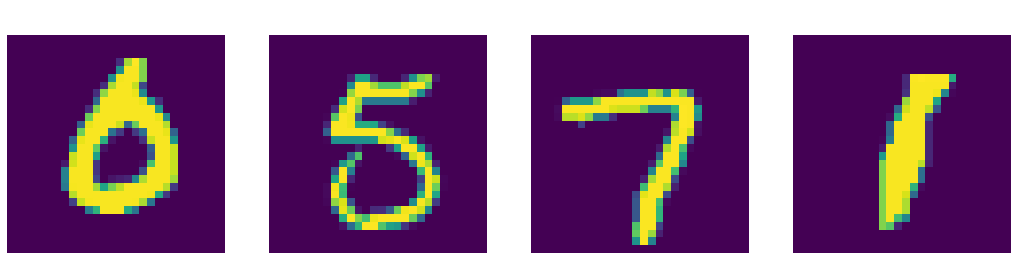

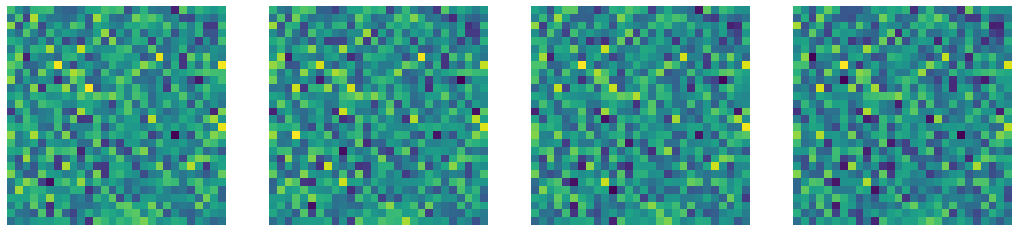

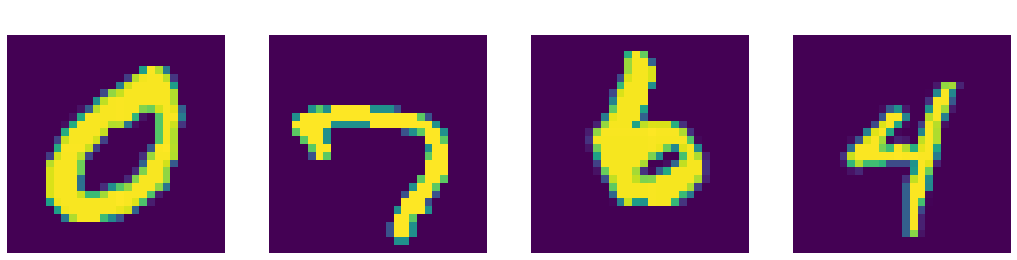

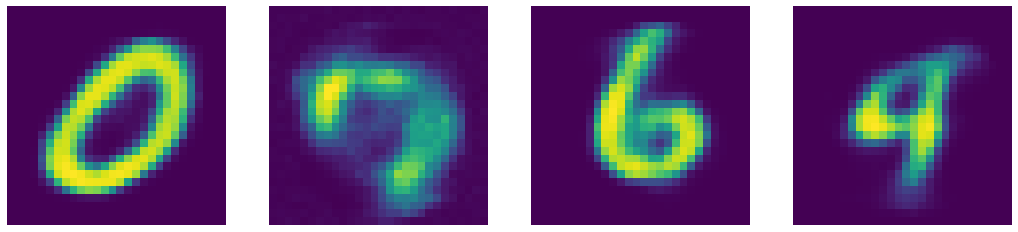

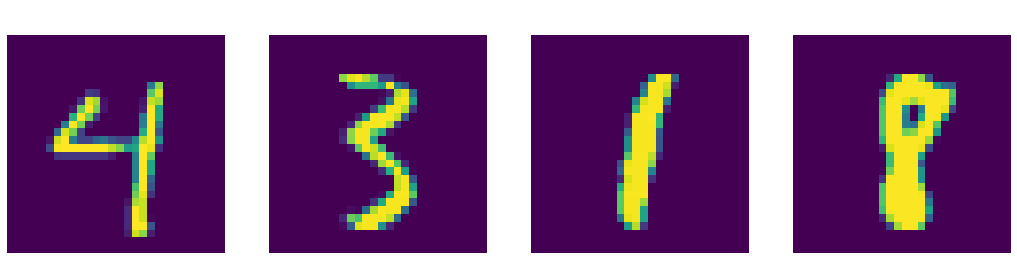

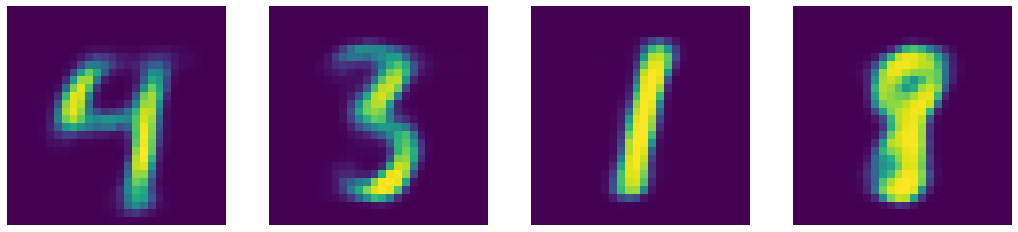

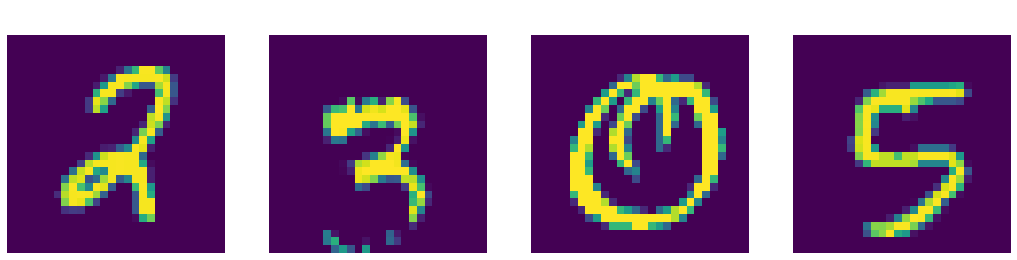

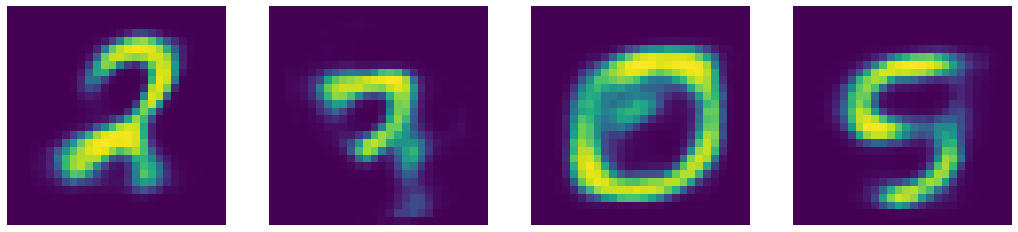

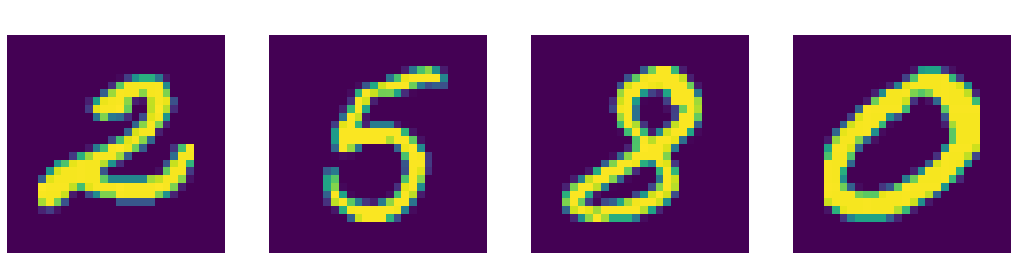

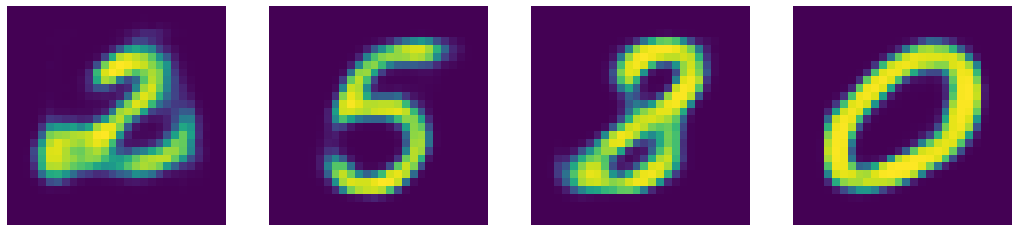

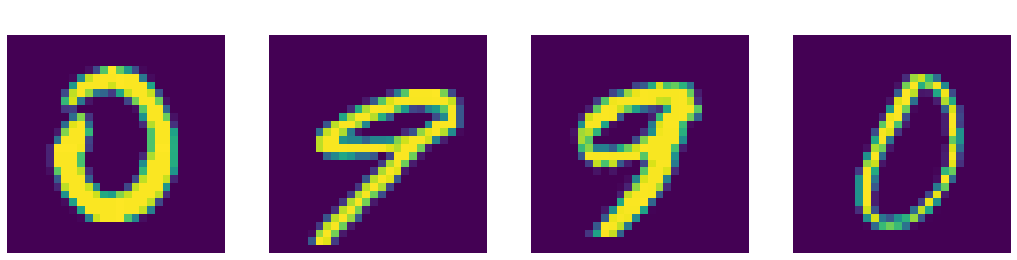

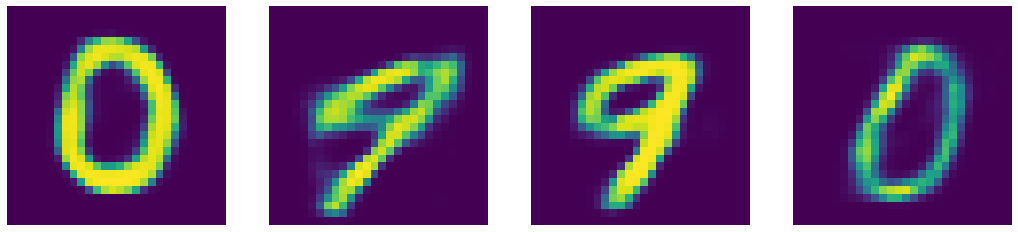

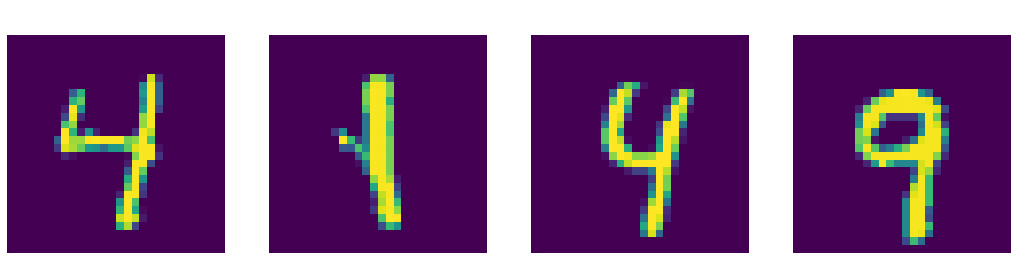

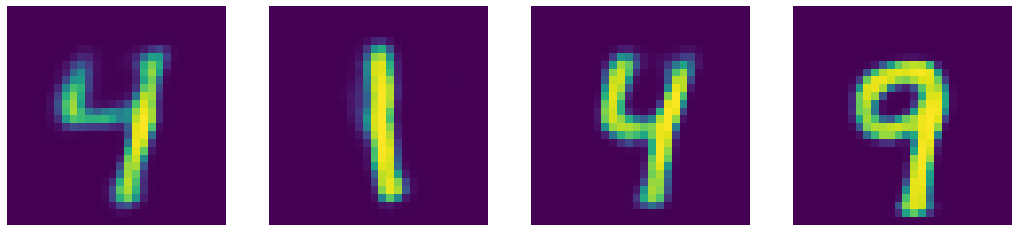

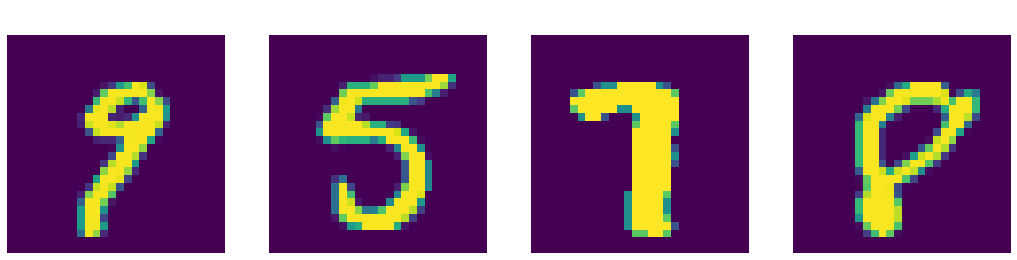

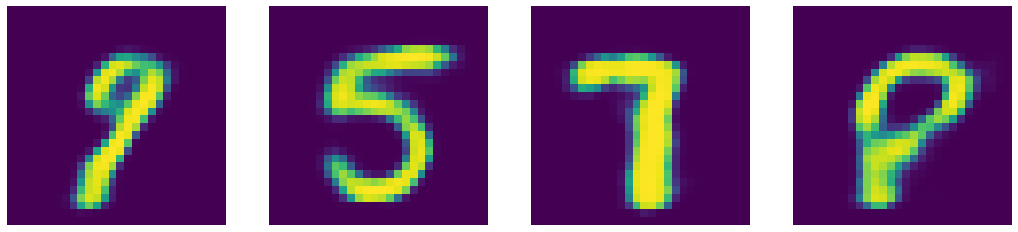

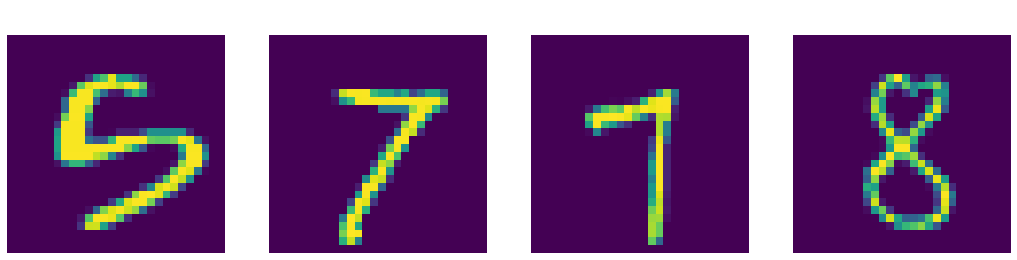

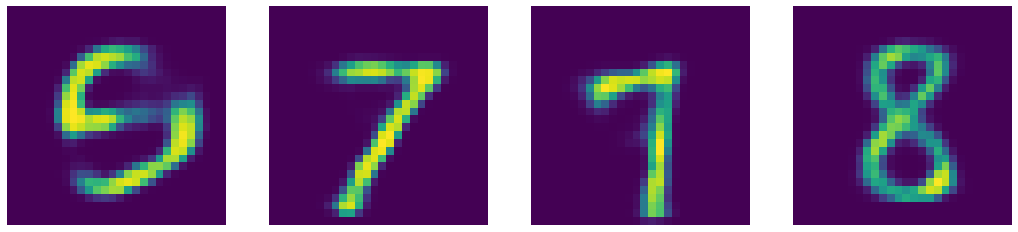

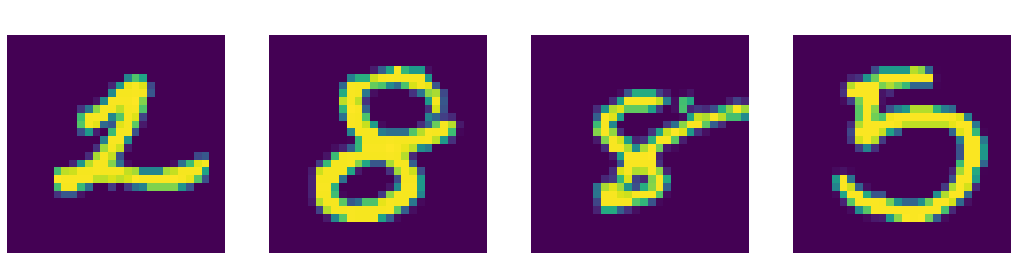

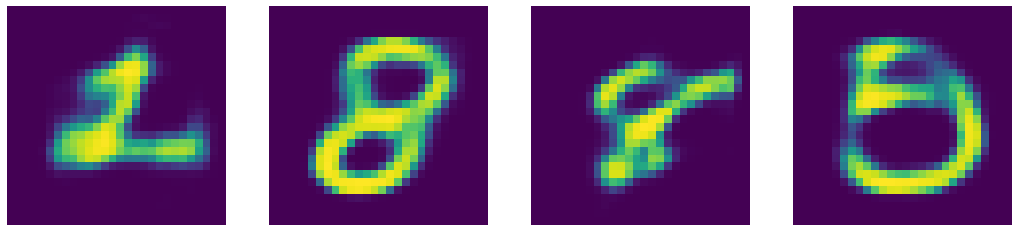

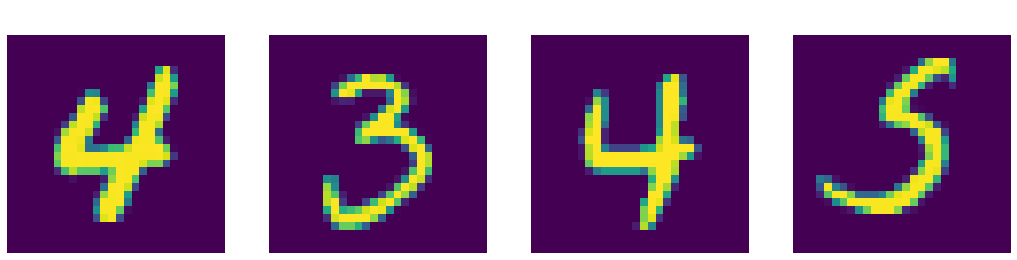

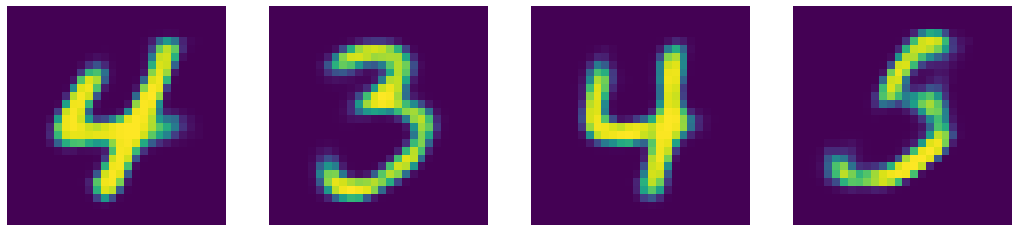

In [9]:
# Training and testing the VAE

epochs = 10
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:            # test untrained net first
        model.train()        # gives the prediction - outputs the decoder, mu and logvar
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)      # Compute the Loss
            train_loss += loss.item()                       # add it to training loss.
            # ===================backward====================
            optimizer.zero_grad()                           # Clean up the gradient
            loss.backward()                                 
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    
    # Testing
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
            
            
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    
    display_images(x, x_hat, 1, f'Epoch {epoch}')

# Generating New Samples

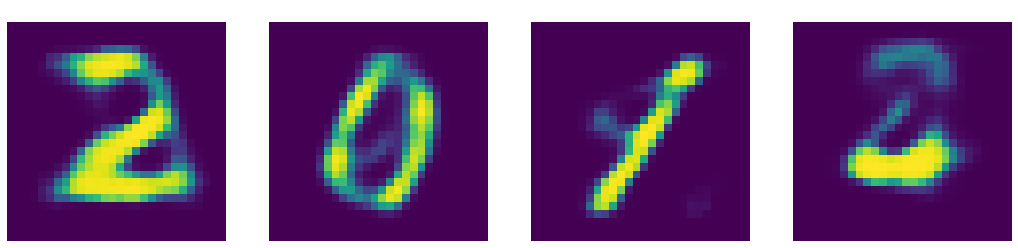

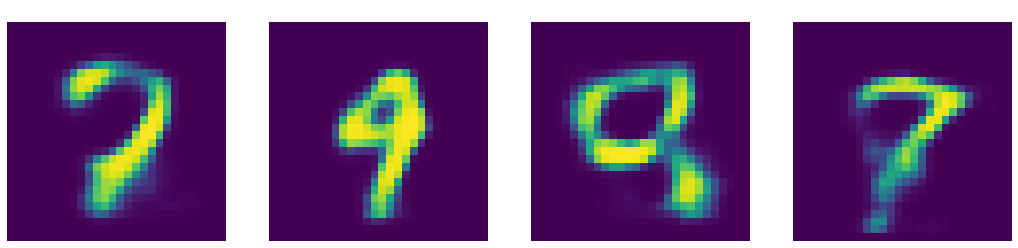

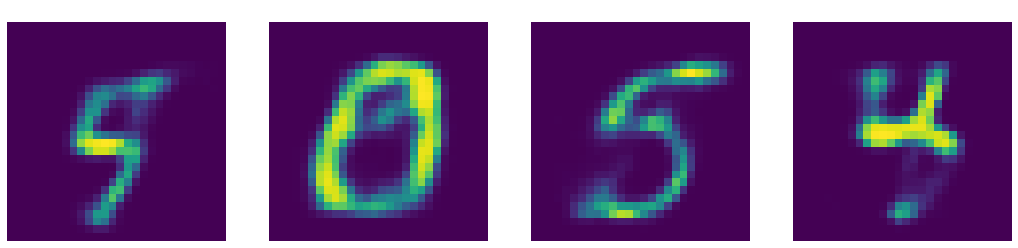

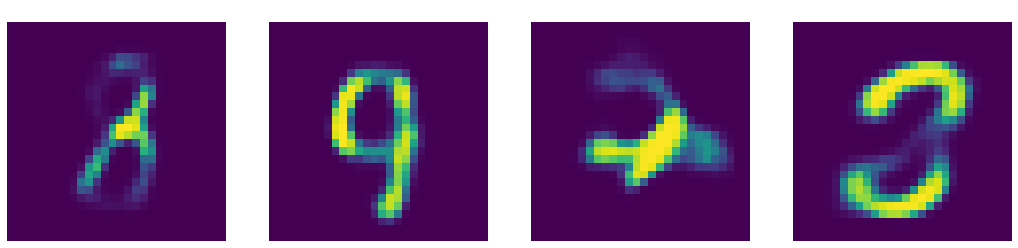

In [10]:
# Generating a few samples

N = 16
z = torch.randn((N, d)).to(device)          # Sample z from a Normal Distribution
sample = model.decoder(z)                   # Sampling from the Latent Distribution using the Decoder.
display_images(None, sample, N // 4, count=True)

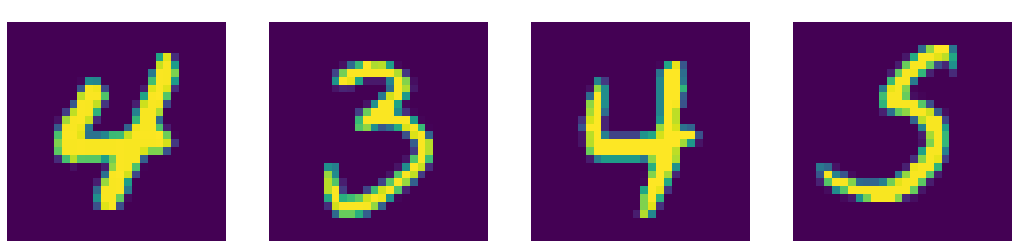

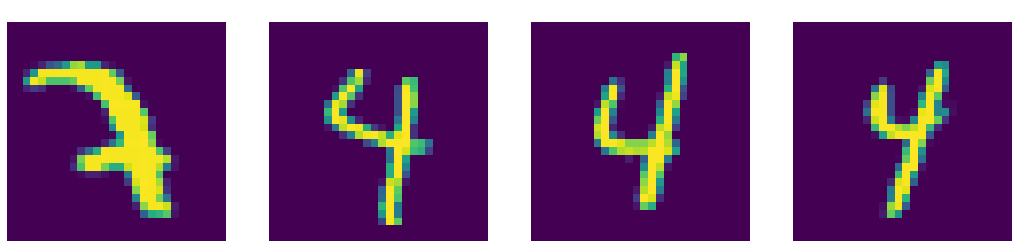

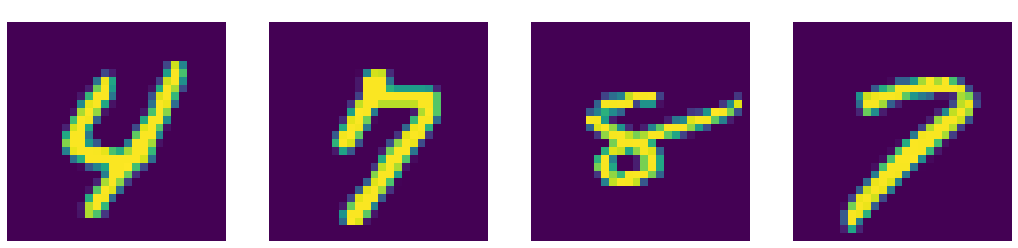

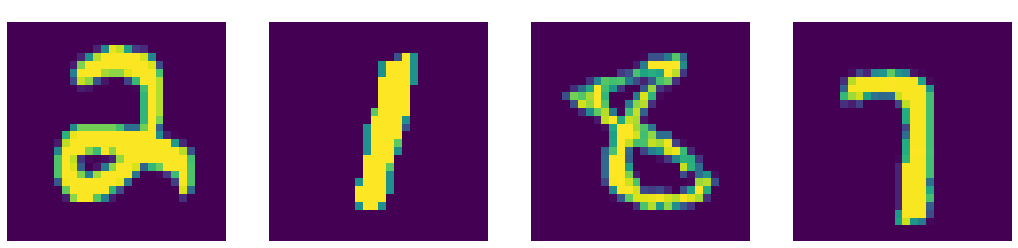

In [11]:
# Display last test batch

display_images(None, x, 4, count=True)

# Linear Interpolation

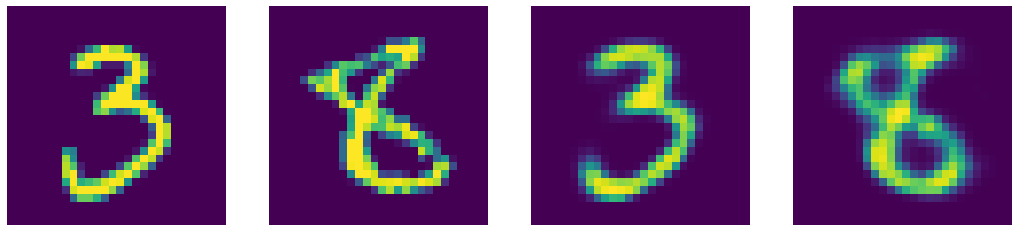

In [12]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

# The first two are original images and the later ones are reconstructed images.

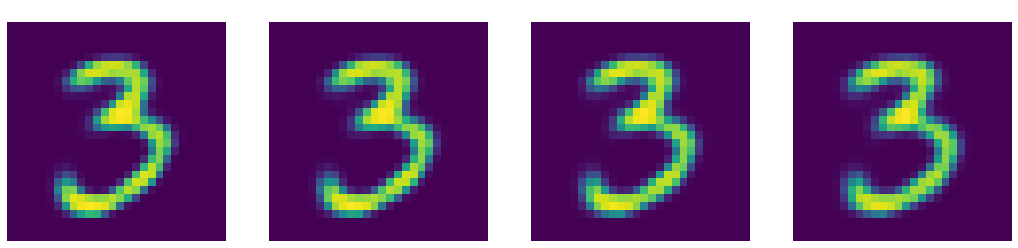

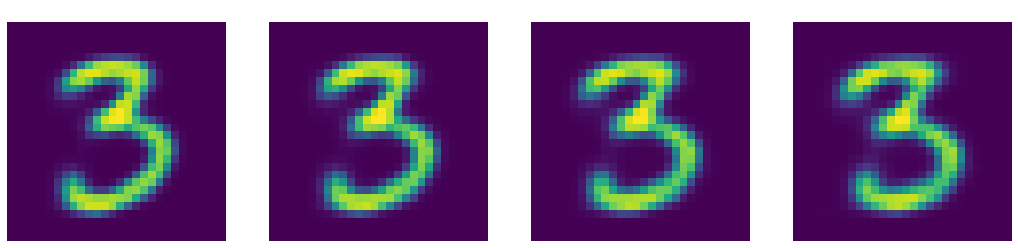

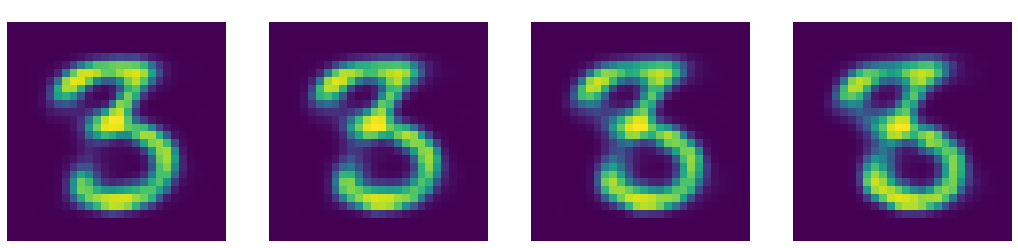

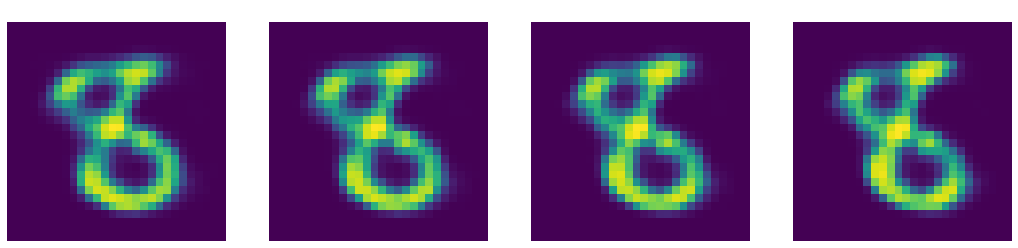

In [13]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

## Embeddings of the Latent Space

In [14]:
import numpy as np
from sklearn.manifold import TSNE
from plot_lib import set_default

In [15]:
set_default(figsize=(15, 4))

In [16]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1]))
    Y.append(codes['y'][epoch][:N])

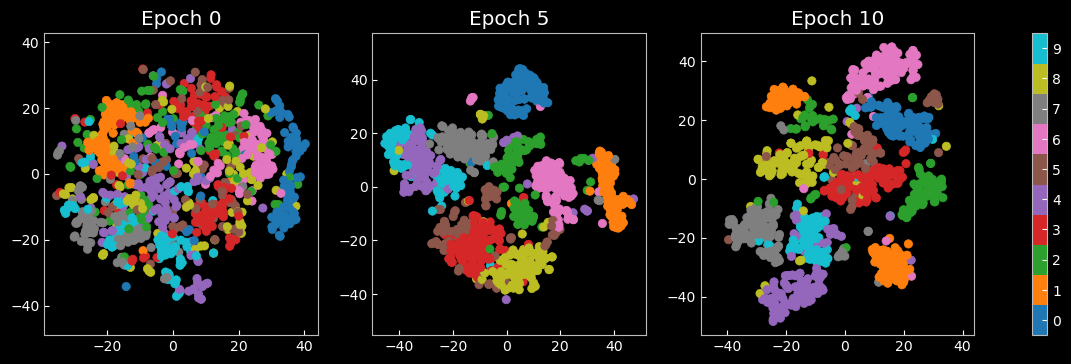

In [17]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')


f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)